In [99]:
from sklearn.cluster import KMeans
import numpy as np
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt
import random
from statistics import mean
import tensorflow as tf
from tqdm import tqdm_notebook
import pandas as pd
from keras.utils import np_utils
import keras
%matplotlib inline

In [100]:
TrainingPercent=0.8
ValidationPercent=0.1
TestPercent=0.1

In [101]:
# Function for data Preprocessing
#Generate Data from file
def GenerateProcessData(sp,dp,hofd):
    Pdata=[]
    P1data=[]
    Tdata=[]
    Fdata=[]
    #object for file
    with open(hofd,'rU') as feature:
        read3=csv.reader(feature)
        #loop for each row of feature
        for row in read3:
            datarow=[]
            #loop for each column in a row
            for column in row:
                datarow.append(column)
            Fdata.append(datarow)
    #reading same and different pair file
    samepair = pd.read_csv(sp)
    diffpair=pd.read_csv(dp)
    #shuffling pair file for random selection
    samepair=samepair.sample(frac=1).reset_index(drop=True)
    diffpair=diffpair.sample(frac=1).reset_index(drop=True)
    #Selecting equal number of pair
    samepair=samepair[:70000]
    diffpair=diffpair[:70000]
    #concatenating same and different pair
    finalpair=pd.concat([samepair,diffpair])
    #Shufflig the final pair for random selection
    finalpair=finalpair.sample(frac=1).reset_index(drop=True)
    #addving values to list
    Pdata=finalpair.values
    print(Pdata.shape)
    #extract Target
    Tdata=Pdata[:,2]
    Tdata=np.array(Tdata,dtype=float)
    
    #delete target from the pair list
    Pdata=np.delete(Pdata,[2],axis=1)
    #Delete title row and column
    Fdata=np.delete(Fdata,[0],axis=0)
    #Fdata=np.delete(Fdata,[0],axis=1)
    return Pdata, Tdata, Fdata

In [102]:
#function for concatenation
def ConcateFeature(Pdata,Fdata):
    Dict=[]
    Dict1=[]
    for row in Pdata:
        for row1 in Fdata:
            #searching Writer 1 in feature dataset
            if row[0] == row1[0]:
                Dict.append(row1)
            #searching Writer 2 in feature dataset
            elif row[1] == row1[0]:
                Dict1.append(row1)
    #deleting Writer name from writer 1 
    print(len(Dict[0]))
    Dict=np.delete(Dict,[0],axis=1)
    print(len(Dict[0]))
    Dict=[[float(j) for j in i]for i in Dict]
    #deleting Writer name from writer 2 
    Dict1=np.delete(Dict1,[0],axis=1)
    Dict1=[[float(j) for j in i]for i in Dict1]
    #concatenating both writer features
    Dict=np.hstack((Dict,Dict1))
    Dict=np.transpose(Dict)
    return Dict
#function for subtraction
def SubstractFeature(Pdata,Fdata):
    Dict=[]
    Dict1=[]
    result=[]
    for row in Pdata:
        for row1 in Fdata:
            if row[0] == row1[0]:
                #searching Writer 1 in feature dataset
                Dict.append(row1)
            elif row[1] == row1[0]:
                #searching Writer 2 in feature dataset
                Dict1.append(row1)
    #deleting Writer name from writer 1 
    Dict=np.delete(Dict,[0],axis=1)
    Dict=[[float(j) for j in i]for i in Dict]
    #deleting Writer name from writer 2
    Dict1=np.delete(Dict1,[0],axis=1)
    Dict1=[[float(j) for j in i]for i in Dict1]
    Dict=np.subtract(Dict,Dict1)
    Dict=np.transpose(Dict)
    return Dict

In [103]:
#Function for Diving dataset into training, validation and testing
#Generate Data for training, validation and testing
def GenerateData(data,percent,UsedData):
    #if data for training
    if (UsedData==0):
        lenght=int(math.ceil(len(data[0])*percent))
        data=data[:,0:lenght]
    #data for testing and validation
    elif (UsedData!=0):
        lenght=int(math.ceil(len(data[0])*percent))
        end=UsedData+lenght
        data=data[:,UsedData+1:end]
    data=np.transpose(data)
    return data
#Generate Target for training, validation and testing
def GenerateTarget(target,percent,UsedData):
    #target for testing
    if UsedData==0 :
        lenght=int(math.ceil(len(target)*percent))
        target=target[0:lenght]
    #target for testing and validation
    elif UsedData!=0 :
        lenght=int(math.ceil(len(target)*percent))
        end=UsedData+lenght
        target=target[UsedData+1:end]
    return target

In [104]:
#processing dataset
Pairs, Target, Features = GenerateProcessData('samepairs.csv','differentpairs.csv','GSCFD.csv')
print(Pairs)
print(Target.shape)
print(Features)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 'U' mode is deprecated
  if __name__ == '__main__':


(140000, 3)
[['0113a_num1.png' '0113a_num2.png']
 ['0005b_num1.png' '0005c_num5.png']
 ['0562a_num4.png' '0562a_num5.png']
 ...
 ['0354a_num1.png' '0354b_num3.png']
 ['0630a_num1.png' '0633a_num3.png']
 ['0078b_num6.png' '0078c_num1.png']]
(140000,)
[['0001a_num1.png' '0' '0' ... '0' '0' '0']
 ['0001a_num2.png' '0' '0' ... '0' '0' '0']
 ['0001a_num3.png' '0' '0' ... '0' '0' '0']
 ...
 ['1568a_num3.png' '0' '0' ... '0' '0' '0']
 ['1568c_num1.png' '0' '0' ... '0' '0' '0']
 ['1568c_num2.png' '0' '0' ... '0' '0' '0']]


In [105]:
#function for concatenation
#comment next two lines and remove # after that for substraction
ConcatFeat=ConcateFeature(Pairs,Features)
print(ConcatFeat.shape)
#function for Subtraction
#SubFeat=SubstractFeature(Pairs,Features)
#print(Sub.shape)

513
512
(1024, 140000)


In [106]:
#generating training data and target
#Change ConcatFeat to SubFeat for subtraction
TrainData=GenerateData(ConcatFeat,TrainingPercent,0)
TrainTarget=np.array(GenerateTarget(Target,TrainingPercent,0))
print(TrainData.shape)
print(TrainTarget.shape)

(112000, 1024)
(112000,)


In [107]:
#generating validation Data and target
#Change ConcatFeat to SubFeat for subtraction
ValData=GenerateData(ConcatFeat,ValidationPercent,len(TrainData))
ValTarget=GenerateTarget(Target,ValidationPercent,len(TrainData))
print(ValData.shape)
print(ValTarget.shape)

(13999, 1024)
(13999,)


In [108]:
#generating Test Data and target
#Change ConcatFeat to SubFeat for subtraction
TestData=GenerateData(ConcatFeat,TestPercent,len(TrainData)+len(ValData))
TestTarget=GenerateTarget(Target,TestPercent,len(TrainData)+len(ValData))
print(TestData.shape)
print(TestTarget.shape)

(13999, 1024)
(13999,)


In [121]:
Hidden_layer=100
Output_layer=1
Learning_rate=0.03
epoch=350
batchsize=40
model=keras.Sequential()
model.add(keras.layers.Dense(Hidden_layer,activation='sigmoid'))
model.add(keras.layers.Dense(Output_layer,activation='sigmoid'))

model.compile(optimizer=tf.train.GradientDescentOptimizer(Learning_rate),loss='binary_crossentropy',metrics=['accuracy'])

In [122]:
history=model.fit(TrainData,TrainTarget,epochs=epoch,batch_size=batchsize,validation_data=(ValData,ValTarget))
predictedTestTarget=model.predict(TestData)
#print(history)
#print(predictedTestTarget.shape)

Train on 112000 samples, validate on 13999 samples
Epoch 1/350
112000/112000 [==============================] - 4s 33us/step - loss: 0.6772 - acc: 0.5735 - val_loss: 0.6681 - val_acc: 0.5996
Epoch 2/350
112000/112000 [==============================] - 3s 30us/step - loss: 0.6379 - acc: 0.6386 - val_loss: 0.6077 - val_acc: 0.6661
Epoch 3/350
112000/112000 [==============================] - 3s 31us/step - loss: 0.5531 - acc: 0.7238 - val_loss: 0.5217 - val_acc: 0.7421
Epoch 4/350
112000/112000 [==============================] - 3s 31us/step - loss: 0.4915 - acc: 0.7631 - val_loss: 0.4821 - val_acc: 0.7643
Epoch 5/350
112000/112000 [==============================] - 4s 31us/step - loss: 0.4570 - acc: 0.7846 - val_loss: 0.4528 - val_acc: 0.7846
Epoch 6/350
112000/112000 [==============================] - 4s 32us/step - loss: 0.4291 - acc: 0.8016 - val_loss: 0.4316 - val_acc: 0.7967
Epoch 7/350
112000/112000 [==============================] - 3s 31us/step - loss: 0.4069 - acc: 0.8161 - val_

Epoch 59/350
112000/112000 [==============================] - 3s 30us/step - loss: 0.0736 - acc: 0.9793 - val_loss: 0.2041 - val_acc: 0.9175
Epoch 60/350
112000/112000 [==============================] - 3s 30us/step - loss: 0.0719 - acc: 0.9797 - val_loss: 0.2076 - val_acc: 0.9178
Epoch 61/350
112000/112000 [==============================] - 3s 30us/step - loss: 0.0703 - acc: 0.9800 - val_loss: 0.2055 - val_acc: 0.9178
Epoch 62/350
112000/112000 [==============================] - 3s 30us/step - loss: 0.0678 - acc: 0.9817 - val_loss: 0.2098 - val_acc: 0.9180
Epoch 63/350
112000/112000 [==============================] - 3s 30us/step - loss: 0.0668 - acc: 0.9821 - val_loss: 0.2072 - val_acc: 0.9178
Epoch 64/350
112000/112000 [==============================] - 3s 30us/step - loss: 0.0648 - acc: 0.9826 - val_loss: 0.2128 - val_acc: 0.9141
Epoch 65/350
112000/112000 [==============================] - 3s 30us/step - loss: 0.0632 - acc: 0.9841 - val_loss: 0.2252 - val_acc: 0.9128
Epoch 66/350


Epoch 117/350
112000/112000 [==============================] - 3s 30us/step - loss: 0.0186 - acc: 0.9998 - val_loss: 0.2395 - val_acc: 0.9187
Epoch 118/350
112000/112000 [==============================] - 3s 30us/step - loss: 0.0183 - acc: 0.9998 - val_loss: 0.2410 - val_acc: 0.9179
Epoch 119/350
112000/112000 [==============================] - 3s 30us/step - loss: 0.0179 - acc: 0.9998 - val_loss: 0.2420 - val_acc: 0.9191
Epoch 120/350
112000/112000 [==============================] - 3s 30us/step - loss: 0.0177 - acc: 0.9998 - val_loss: 0.2413 - val_acc: 0.9182
Epoch 121/350
112000/112000 [==============================] - 3s 30us/step - loss: 0.0173 - acc: 0.9999 - val_loss: 0.2423 - val_acc: 0.9185
Epoch 122/350
112000/112000 [==============================] - 3s 30us/step - loss: 0.0169 - acc: 0.9998 - val_loss: 0.2467 - val_acc: 0.9176
Epoch 123/350
112000/112000 [==============================] - 3s 30us/step - loss: 0.0166 - acc: 0.9999 - val_loss: 0.2438 - val_acc: 0.9179
Epoch 

112000/112000 [==============================] - 3s 30us/step - loss: 0.0082 - acc: 1.0000 - val_loss: 0.2711 - val_acc: 0.9168
Epoch 175/350
112000/112000 [==============================] - 3s 30us/step - loss: 0.0081 - acc: 1.0000 - val_loss: 0.2684 - val_acc: 0.9179
Epoch 176/350
112000/112000 [==============================] - 3s 30us/step - loss: 0.0080 - acc: 1.0000 - val_loss: 0.2709 - val_acc: 0.9174
Epoch 177/350
112000/112000 [==============================] - 3s 31us/step - loss: 0.0079 - acc: 1.0000 - val_loss: 0.2714 - val_acc: 0.9174
Epoch 178/350
112000/112000 [==============================] - 3s 30us/step - loss: 0.0078 - acc: 1.0000 - val_loss: 0.2744 - val_acc: 0.9164
Epoch 179/350
112000/112000 [==============================] - 3s 30us/step - loss: 0.0077 - acc: 1.0000 - val_loss: 0.2707 - val_acc: 0.9180
Epoch 180/350
112000/112000 [==============================] - 3s 30us/step - loss: 0.0076 - acc: 1.0000 - val_loss: 0.2737 - val_acc: 0.9171
Epoch 181/350
112000

Epoch 232/350
112000/112000 [==============================] - 3s 30us/step - loss: 0.0048 - acc: 1.0000 - val_loss: 0.2893 - val_acc: 0.9168
Epoch 233/350
112000/112000 [==============================] - 3s 30us/step - loss: 0.0048 - acc: 1.0000 - val_loss: 0.2910 - val_acc: 0.9159
Epoch 234/350
112000/112000 [==============================] - 3s 30us/step - loss: 0.0048 - acc: 1.0000 - val_loss: 0.2901 - val_acc: 0.9169
Epoch 235/350
112000/112000 [==============================] - 3s 30us/step - loss: 0.0047 - acc: 1.0000 - val_loss: 0.2910 - val_acc: 0.9169
Epoch 236/350
112000/112000 [==============================] - 3s 30us/step - loss: 0.0047 - acc: 1.0000 - val_loss: 0.2921 - val_acc: 0.9172
Epoch 237/350
112000/112000 [==============================] - 3s 31us/step - loss: 0.0047 - acc: 1.0000 - val_loss: 0.2913 - val_acc: 0.9166
Epoch 238/350
112000/112000 [==============================] - 4s 35us/step - loss: 0.0046 - acc: 1.0000 - val_loss: 0.2910 - val_acc: 0.9176
Epoch 

112000/112000 [==============================] - 3s 31us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.3035 - val_acc: 0.9167
Epoch 290/350
112000/112000 [==============================] - 3s 31us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.3053 - val_acc: 0.9164
Epoch 291/350
112000/112000 [==============================] - 3s 31us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.3047 - val_acc: 0.9161
Epoch 292/350
112000/112000 [==============================] - 3s 31us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.3043 - val_acc: 0.9165
Epoch 293/350
112000/112000 [==============================] - 3s 31us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.3047 - val_acc: 0.9161
Epoch 294/350
112000/112000 [==============================] - 3s 31us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.3063 - val_acc: 0.9161
Epoch 295/350
112000/112000 [==============================] - 3s 31us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.3051 - val_acc: 0.9166
Epoch 296/350
112000

Epoch 347/350
112000/112000 [==============================] - 3s 31us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.3146 - val_acc: 0.9165
Epoch 348/350
112000/112000 [==============================] - 3s 31us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.3151 - val_acc: 0.9164
Epoch 349/350
112000/112000 [==============================] - 3s 31us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.3153 - val_acc: 0.9165
Epoch 350/350
112000/112000 [==============================] - 3s 30us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.3152 - val_acc: 0.9167


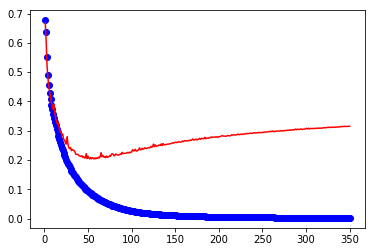

In [123]:
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.show()

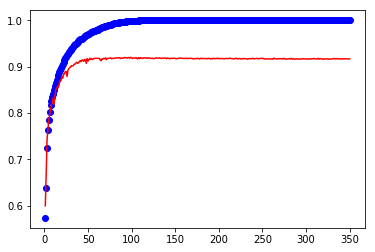

In [124]:
plt.clf()
plt.plot(epochs,acc,'bo',label='Training Acc')
plt.plot(epochs,val_acc,'r',label='Validation acc')
plt.show()

In [125]:
Loss, accu=model.evaluate(TestData,TestTarget)
print("Loss",Loss)
print("Accu",accu)

13999/13999 [==============================] - 0s 18us/step
Loss 0.29455378696804635
Accu 0.9206371883791135


In [126]:
total=0.0
counter=0
for i in range(0,len(predictedTestTarget)):
    total+=math.pow((TestTarget[i]-predictedTestTarget[i]),2)
    #Count number of match
    if (int(np.around(predictedTestTarget[i])) == TestTarget[i]):
        counter+=1
Accuracy=(counter*100/len(predictedTestTarget))
Erms=math.sqrt(total/len(predictedTestTarget))

print("Errors: " + str(len(predictedTestTarget)-counter), " Correct :" + str(counter))

print("Testing Accuracy: " + str(Accuracy))
print("Testing Erms: " + str(Erms))

Errors: 1111  Correct :12888
Testing Accuracy: 92.0637188370598
Testing Erms: 0.2531278842149712
